In [1]:
import itertools
import pandas as pd
import chardet

data_path = '../data/300k_dataset_res.csv'
data_description_path = '../data/data_description.csv'

In [2]:
data = pd.read_csv(data_path)

with open(data_description_path, 'rb') as file:
    raw_data = file.read()
    encoding = chardet.detect(raw_data)['encoding']
data_description = pd.read_csv(data_description_path, encoding=encoding)
features = data_description[data_description['Relative importance']>8]['Feature (nl)'].tolist()
print(len(features))

25


In [5]:
def is_fair(dataset, feature, result_col, threshold=0.1):
    group = dataset.groupby(feature)
    distributions = group[result_col].value_counts(normalize=True)
    # print(f"{feature} has {len(distributions)} values")

    prob_result_1 = distributions[:, 1].reset_index(name='prob_1')
    max_diff = prob_result_1['prob_1'].max() - prob_result_1['prob_1'].min()
    # print(f"Max probability difference for result=1: {max_diff:.4f}")
    return max_diff <= threshold, round(max_diff, 4)

def find_unfair_feature(dataset,features, result_col):
    biased_features = {}
    for feature in features:
        fair, diff = is_fair(dataset, feature, result_col)
        if not fair:
            biased_features[feature] = diff
    return biased_features

result_1 = find_unfair_feature(data, features, 'model_1')
result_1 = dict(sorted(result_1.items(), key=lambda item: item[0], reverse=False))
print(f"the biased features for model 1 is :\n{result_1}")
result_2 = find_unfair_feature(data, features, 'model_2')
result_2 = dict(sorted(result_2.items(), key=lambda item: item[0], reverse=False))
print(f"the biased features for model 2 is :\n{result_2}")


the biased features for model 1 is :
{'adres_dagen_op_adres': np.float64(0.4706), 'afspraak_resultaat_ingevuld_uniek': np.float64(0.4965), 'belemmering_dagen_financiele_problemen': np.float64(0.9831), 'contacten_soort_afgelopenjaar_document__uitgaand_': np.float64(0.1735), 'ontheffing_dagen_hist_mean': np.float64(0.9953), 'ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden': np.float64(0.9925), 'persoon_leeftijd_bij_onderzoek': np.float64(0.1493), 'persoonlijke_eigenschappen_dagen_sinds_opvoer': np.float64(0.2473), 'persoonlijke_eigenschappen_dagen_sinds_taaleis': np.float64(0.2476), 'relatie_partner_totaal_dagen_partner': np.float64(0.993)}
the biased features for model 2 is :
{'adres_dagen_op_adres': np.float64(0.9643), 'afspraak_inspanningsperiode': np.float64(0.1495), 'afspraak_resultaat_ingevuld_uniek': np.float64(0.4772), 'belemmering_dagen_financiele_problemen': np.float64(0.9804), 'competentie_vakdeskundigheid_toepassen': np.float64(0.7872), 'contacten_onderwerp_no_show':

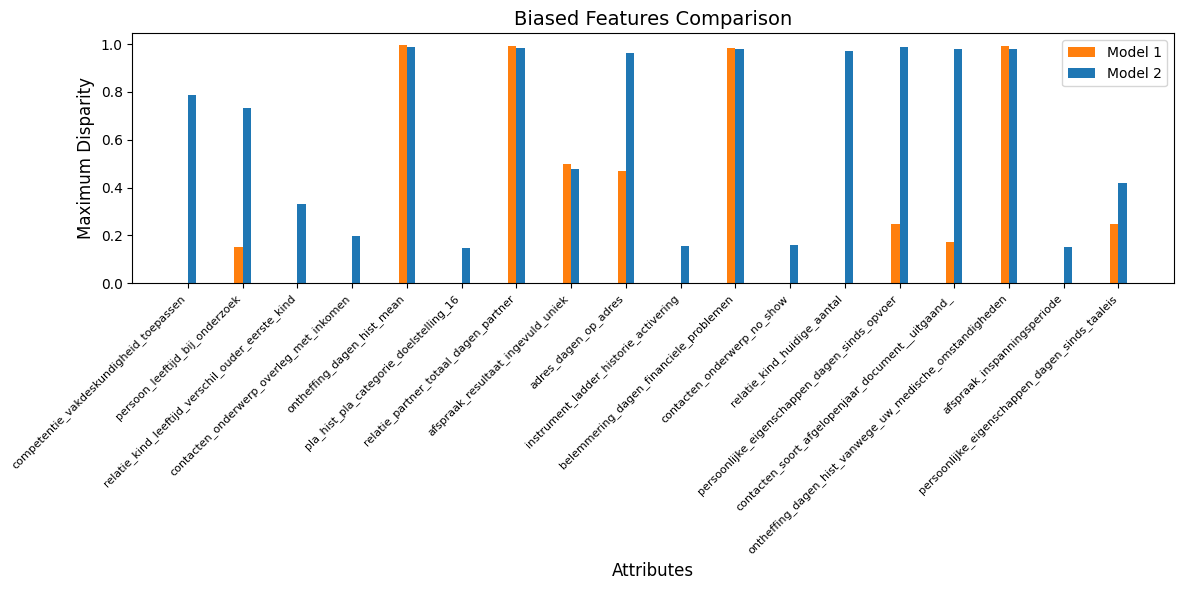

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# x-axis
attributes = list(set(result_1.keys()).union(set(result_2.keys())))

# y-axis values for both result_1 and result_2
values_1 = [result_1.get(attr, 0) for attr in attributes]
values_2 = [result_2.get(attr, 0) for attr in attributes]

x = np.arange(len(attributes))  # positions for bars
width = 0.15  # bar width

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, values_1, width, label='Model 1', color = 'tab:orange')
rects2 = ax.bar(x + width/2, values_2, width, label='Model 2', color = 'tab:blue')

# Add labels, title, and legend
ax.set_xlabel('Attributes', fontsize=12)
ax.set_ylabel('Maximum Disparity', fontsize=12)
ax.set_title('Biased Features Comparison', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(attributes, rotation=45, ha='right', fontsize=8)
ax.legend()

# Adjust layout for better fit
plt.tight_layout()
plt.savefig('../images/biased_features_comparison_2.png')
plt.show()
